# Performance of Gradient Boosting Algorithms on a Numeric Dataset

### This Notebook contains the comparative analysis of 3 Boosting Algorithms - 
### XGBoost, CatBoost and LightGBM trained and tested on a Numeric Dataset 



In [0]:
#Installing the 3 boosting algorithms
!pip install xgboost
!pip install catboost
!pip install lightgbm

In [0]:
# Importing Dependencies
import numpy as np
import pandas as pd
import sys
import os
import warnings
from datetime import datetime
import matplotlib as mpl
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from catboost import Pool,CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
warnings.filterwarnings("ignore")
#Setting Up matplotlib
%matplotlib inline
mpl.style.reload_library()
mpl.style.use('classic')
mpl.rcParams['figure.facecolor'] = (1, 1, 1, 0)
mpl.rcParams['figure.figsize'] = [6.0, 4.0]
mpl.rcParams['figure.dpi'] = 100

## We use the Pokemon Numeric Dataset which can be found [here](https://www.kaggle.com/mlomuscio/pokemon).

Reading the Dataset

In [0]:
input_path = r"/content/drive/My Drive/IBM/Pokemon_Numeric.csv"
data = pd.read_csv(input_path)

#### The goal is to predict whether a Pokemon is Legendary or not, given specific characteristics of each pokemon; such as Attack, Defense, Generation etc.

### Preliminary Analysis

In [0]:
# Checking Basic information available from dataset
data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        800 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      414 non-null    object
 4   Total       800 non-null    int64 
 5   HP          800 non-null    int64 
 6   Attack      800 non-null    int64 
 7   Defense     800 non-null    int64 
 8   Sp. Atk     800 non-null    int64 
 9   Sp. Def     800 non-null    int64 
 10  Speed       800 non-null    int64 
 11  Generation  800 non-null    object
 12  Legendary   800 non-null    bool  
dtypes: bool(1), int64(8), object(4)
memory usage: 75.9+ KB


In [0]:
data[['HP', 'Attack', 'Defense']].head()
data[['HP', 'Attack', 'Defense']].describe()

,HP,Attack,Defense
count,800.000000,800.000000,800.000000
mean,69.258750,79.001250,73.842500
std,25.534669,32.457366,31.183501
min,1.000000,5.000000,5.000000
25%,50.000000,55.000000,50.000000
50%,65.000000,75.000000,70.000000
75%,80.000000,100.000000,90.000000
max,255.000000,190.000000,230.000000


Gaining some Insight into the data available

In [0]:
# Isolated table of Attack and Defense features
atk_def = data[['Attack', 'Defense']]
atk_def.head()

,Attack,Defense
0,49,49
1,62,63
2,82,83
3,100,123
4,52,43


Polynomial Transformation

In [0]:
# Figuring out the polynomial features and performing the transformation
from sklearn.preprocessing import PolynomialFeatures
pf = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
res = pf.fit_transform(atk_def)
res

array([[   49.,    49.,  2401.,  2401.,  2401.],
       [   62.,    63.,  3844.,  3906.,  3969.],
       [   82.,    83.,  6724.,  6806.,  6889.],
       ...,
       [  110.,    60., 12100.,  6600.,  3600.],
       [  160.,    60., 25600.,  9600.,  3600.],
       [  110.,   120., 12100., 13200., 14400.]])

In [0]:
# New dataframe with polynomial features included
pd.DataFrame(pf.powers_, columns=['Attack_degree', 'Defense_degree'])
intr_features = pd.DataFrame(res, columns=['Attack', 'Defense', 'Attack^2', 'Attack x Defense', 'Defense^2'])
intr_features.head(5)

,Attack,Defense,Attack^2,Attack x Defense,Defense^2
0,49.0,49.0,2401.0,2401.0,2401.0
1,62.0,63.0,3844.0,3906.0,3969.0
2,82.0,83.0,6724.0,6806.0,6889.0
3,100.0,123.0,10000.0,12300.0,15129.0
4,52.0,43.0,2704.0,2236.0,1849.0


### **Data Visualizations**

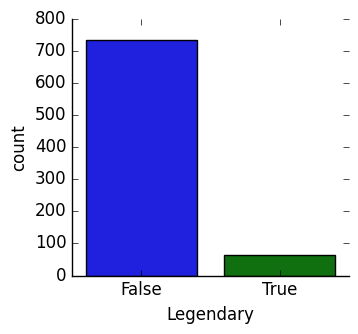

In [0]:
import seaborn as sns
from matplotlib import pyplot as plt
# Ground Truth Values of whether a pokemon is legendary or not
sns.factorplot('Legendary',data=data,kind='count',size = 3.5)

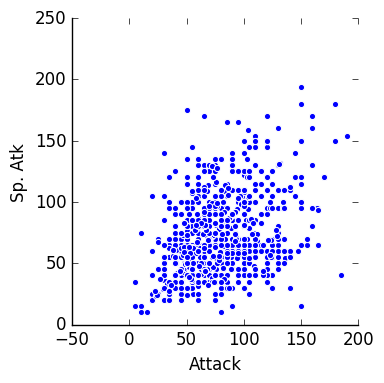

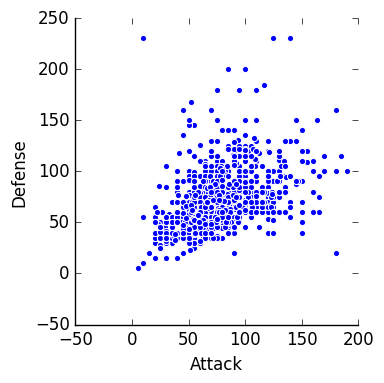

In [0]:
sns.relplot(x = "Attack",y = "Sp. Atk",data = data,height = 4,aspect = 1)
sns.relplot(x = "Attack",y = "Defense",data = data,height = 4,aspect = 1)

As seen from the plots there is a strong correlation between the Features "Attack" and "Defense" w.r.t "Legendary" 

We Also retain the other numerical feature "Sp. Atk" as it also shows considerable correlation with "Attack"

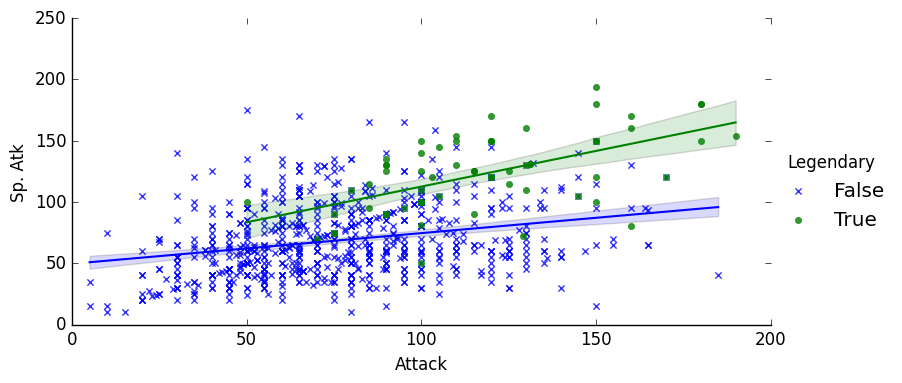

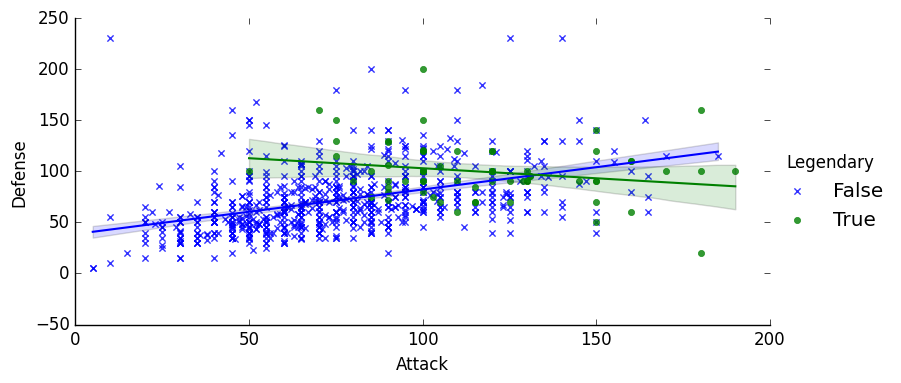

In [0]:
sns.lmplot(x = "Attack",y = "Sp. Atk",hue = "Legendary", markers = ['x','o'],data = data,height = 4,aspect = 2)
sns.lmplot(x = "Attack",y = "Defense",hue = "Legendary", markers = ['x','o'],data = data,height = 4,aspect = 2)

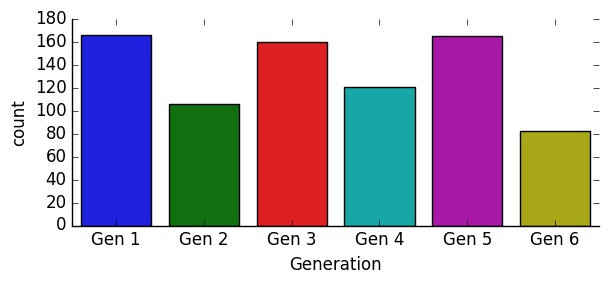

In [0]:
sns.factorplot('Generation',data=data,kind='count',height = 3,aspect = 2)
# Generation Count

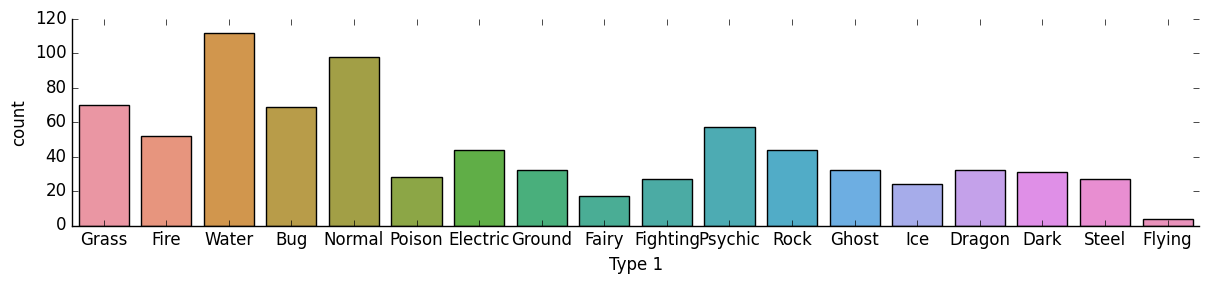

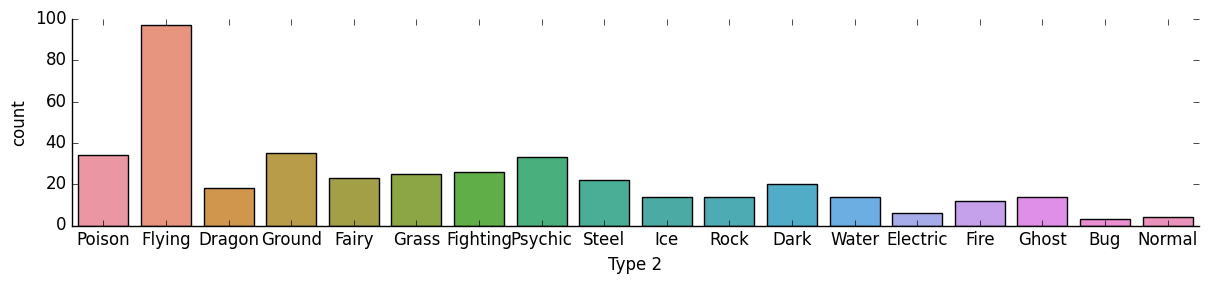

In [0]:
# Analyzing the columns of Type 1 and Type 2
sns.factorplot('Type 1',data=data,kind='count',height = 3,aspect=4)
sns.factorplot('Type 2',data=data,kind='count',height = 3,aspect = 4)

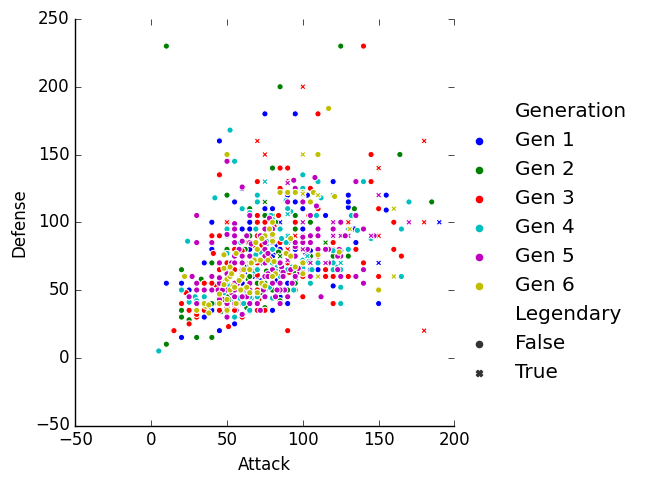

In [0]:
"""
The correlation scatter plot of attack and defense w.r.t Generation categorized on whether
the pokemon is legendary or not 
"""
sns.relplot(x="Attack", y="Defense", hue="Generation", style="Legendary", data=data)

Since All the generations are approximately distributed around the mean of "Attack" and "Defense", we include them in our Predictions too 

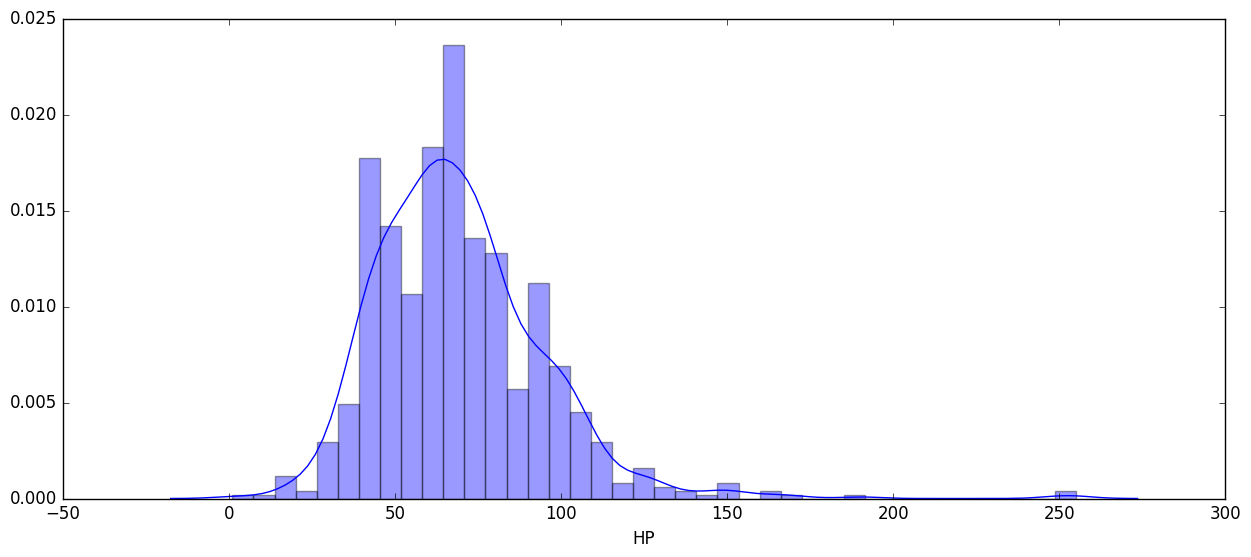

In [0]:
# Visualizing the mean of HP
plt.figure(figsize = (15,6))
sns.distplot(data['HP'])

The following plot depicts the Generation by Generation Distribution of HP and also describes which of them are Legendary

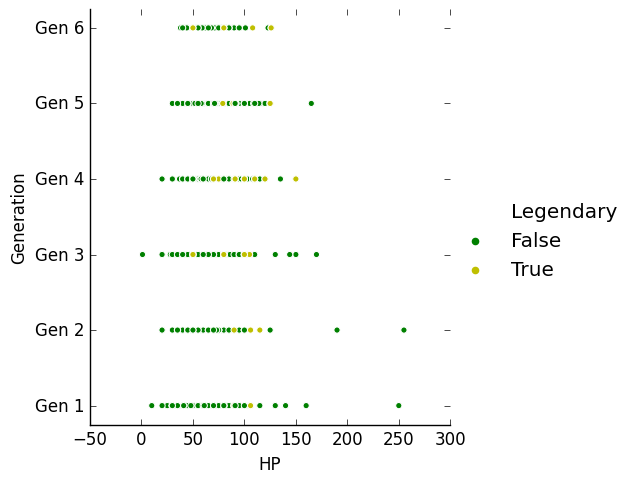

In [0]:
g = sns.relplot(x="HP", y="Generation", hue="Legendary",
                palette=["g", "y"], sizes=(10, 100), data=data)

From the above Plot it is clear that the outliers in the data are minimal

Removing NaN's

In [0]:
print(data.isnull().sum())
# There are 386 Null values within the data, and are only in column "Type 2"

#               0
Name            0
Type 1          0
Type 2        386
Total           0
HP              0
Attack          0
Defense         0
Sp. Atk         0
Sp. Def         0
Speed           0
Generation      0
Legendary       0
dtype: int64


In [0]:
# Populating The Null values with the statistical mode 

data['Type 2'].loc[(data['Type 2'].isnull())] = data['Type 2'].mode().max()
print(data['Type 2'].head(12))


0     Poison
1     Poison
2     Poison
3     Poison
4     Flying
5     Flying
6     Flying
7     Dragon
8     Flying
9     Flying
10    Flying
11    Flying
Name: Type 2, dtype: object


We see from the following plot, that Generation 2 and Generation 5 have the highest Probabilities of the Pokemon being Legendary

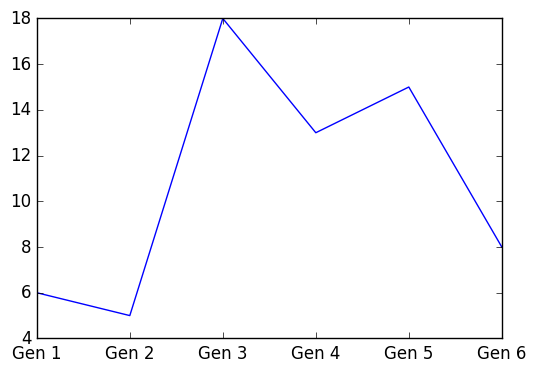

In [0]:
df = data[data["Legendary"] == True].groupby(data["Generation"]).sum()
plt.plot(df['Legendary'])
plt.show()

Encoding the Columns containing Categorical Features (Type 1,Type 2, Generation) to Numeric using the Label Encoder Transformation

In [0]:
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()
data['Type 1'] = LE.fit_transform(data['Type 1'])
data['Type 2'] = LE.fit_transform(data['Type 2'])
data['Generation'] = LE.fit_transform(data['Generation'])
data.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,9,13,318,45,49,49,65,65,45,0,False
1,2,Ivysaur,9,13,405,60,62,63,80,80,60,0,False
2,3,Venusaur,9,13,525,80,82,83,100,100,80,0,False
3,3,VenusaurMega Venusaur,9,13,625,80,100,123,122,120,80,0,False
4,4,Charmander,6,7,309,39,52,43,60,50,65,0,False


# Training and Testing

In [0]:
train,test = train_test_split(data,test_size = 0.3,shuffle = True)
train_x,train_y = train[['Type 1','Type 2','Total','HP','Attack','Defense','Sp. Atk', 'Sp. Def','Speed','Generation']],train["Legendary"]
test_x,test_y = test[['Type 1','Type 2','Total','HP','Attack','Defense','Sp. Atk', 'Sp. Def','Speed','Generation']],test["Legendary"]

#### 1. LightGBM Algorithm on the Dataset




In [0]:
params = {'num_leaves':150, 'objective':'binary','max_depth':7,'learning_rate':.05,'max_bin':200}
params['metric'] = ['auc', 'binary_logloss']

train_data=lgb.Dataset(train_x,label=train_y)

num_round=50
t1=datetime.now()
lgbm=lgb.train(params,train_data,num_round)
t2=datetime.now()
execution_time_lgbm = t2-t1
t3 = datetime.now()
ypred2=lgbm.predict(test_x)
t4 = datetime.now()

for i in range(0,len(ypred2)): 
    if ypred2[i] >=0.5:
        ypred2[i] = 1
    else:
        ypred2[i] = 0
accuracy_lgbm = round(accuracy_score(ypred2,test_y),5)
print("Accuracy score = ",accuracy_lgbm*100,"%")
print("Execution time = ",execution_time_lgbm)
print("Prediction time = ",t4-t3)
lgbm_train_time = t2-t1

Accuracy score =  94.583 %
Execution time =  0:00:00.040244
Prediction time =  0:00:00.002430


#### 2. CatBoost Algorithm on the Dataset

In [0]:
params = {'num_leaves':150, 'objective':'binary','max_depth':7,'learning_rate':.05,'max_bin':200}
params['metric'] = ['auc', 'binary_logloss']
num_round=50
cat_features = np.where(train_x.dtypes!=float)[0]
model = CatBoostClassifier(loss_function = 'Logloss',eval_metric = 'AUC',task_type = 'GPU',learning_rate = 0.1,
                           iterations = 50,l2_leaf_reg = 4, random_seed = 42,od_type = 'Iter',depth = 12,silent = True)
t1=datetime.now()
model.fit(train_x,train_y,cat_features = cat_features)
t2=datetime.now()
execution_time_cat_boost = t2-t1
t3 = datetime.now()
pred = model.predict_proba(test_x)[:,1]
t4 = datetime.now()
accuracy_cat_boost = round(roc_auc_score(test_y,pred),5)
print("Accuracy score = ",accuracy_cat_boost*100,"%")
print("Execution time = ",execution_time_cat_boost)
print("Prediction time = ",t4-t3)
cat_boost_train_time = t2-t1

Accuracy score =  98.206 %
Execution time =  0:00:02.138799
Prediction time =  0:00:00.009027


#### 3. XGBoost Algorithm on the Dataset

In [0]:
model = XGBClassifier()
t1=datetime.now()
model.fit(train_x,train_y)
t2=datetime.now()
execution_time_xgb = t2-t1
t3 = datetime.now()
y_pred = model.predict(test_x)
t4 = datetime.now()
predictions = [round(value) for value in y_pred]
accuracy_xgb = round(accuracy_score(y_pred,test_y),5)
print("Accuracy score = ",accuracy_xgb*100,"%")
print("Execution time = ",execution_time_xgb)
print("Prediction time = ",t4-t3)
xgb_train_time = t2-t1

Accuracy score =  93.333 %
Execution time =  0:00:00.268942
Prediction time =  0:00:00.002103


# Results and Plots

### 1. Accuracy Plot

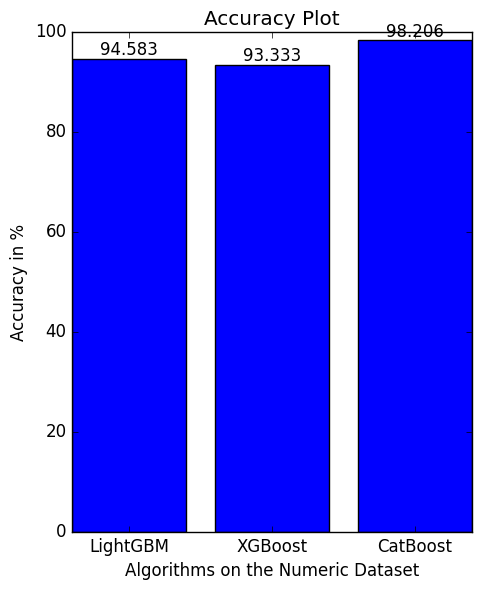

In [0]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (4,5))
ax = fig.add_axes([0,0,1,1])
algorithms = ['LightGBM','XGBoost','CatBoost']
accuracy = [accuracy_lgbm*100, accuracy_xgb*100,accuracy_cat_boost*100]
g = ax.bar(algorithms,accuracy)
plt.title("Accuracy Plot")
plt.xlabel("Algorithms on the Numeric Dataset")
plt.ylabel("Accuracy in %")
bar_label = [accuracy_lgbm*100, accuracy_xgb*100,accuracy_cat_boost*100]
def autolabel(rects):
    for idx,rect in enumerate(g):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.0*height,
                bar_label[idx],
                ha='center', va='bottom', rotation=0)

autolabel(g)
plt.show()

### 2. Training Time  Plot

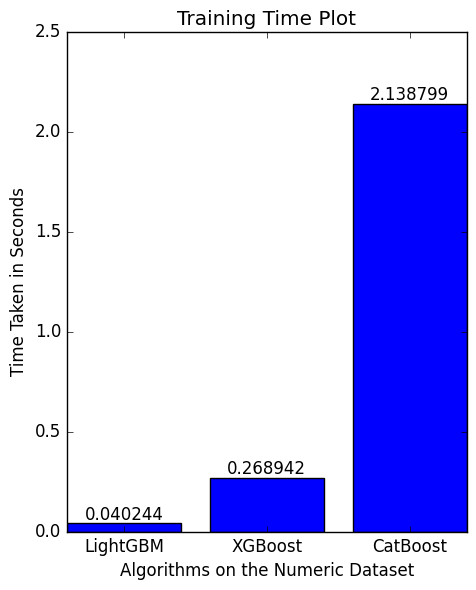

In [0]:
lg = float(str(lgbm_train_time)[5:])
cb = float(str(cat_boost_train_time)[5:])
xgb = float(str(xgb_train_time)[5:])
fig1 = plt.figure(figsize = (4,5))
ay = fig1.add_axes([0,0,1,1])
algorithms = ['LightGBM','XGBoost','CatBoost']
training_time = [lg,xgb,cb]
g1 = ay.bar(algorithms,training_time)
plt.title("Training Time Plot")
plt.xlabel("Algorithms on the Numeric Dataset")
plt.ylabel("Time Taken in Seconds")
bar_label = training_time
def autolabel1(rects):
    for idx,rect in enumerate(g1):
        height = rect.get_height()
        ay.text(rect.get_x() + rect.get_width()/2., 1.0*height,
                bar_label[idx],
                ha='center', va='bottom', rotation=0)

autolabel1(g1)
plt.show()